In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 超参数设置
random_seed = 0
generator_learning_rate = 0.0005
discriminator_learning_rate = 0.0005
NUM_EPOCHS = 100
BATCH_SIZE = 128
LATENT_DIM = 50
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

## WGAN 参数设置
num_iter_critic = 5
weight_clip_value = 0.01


In [3]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

In [4]:
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)


class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [5]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [6]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device)

       
        # WGAN
        valid = -(torch.ones(targets.size(0)).float()).to(device)
        fake = torch.ones(targets.size(0)).float().to(device)
        

        ### FORWARD AND BACK PROP
        
        
        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features)
        
        
        # Regular GAN:
        # gener_loss = F.binary_cross_entropy_with_logits(discr_pred, valid)
        
        # WGAN:
        gener_loss = wasserstein_loss(valid, discr_pred)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        

        
        # WGAN: 5 loops for discriminator
        for _ in range(num_iter_critic):
        
            discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
            # Regular GAN:
            # real_loss = F.binary_cross_entropy_with_logits(discr_pred_real, valid)
            # WGAN:
            real_loss = wasserstein_loss(valid, discr_pred_real)

            discr_pred_fake = model.discriminator_forward(generated_features.detach())

            # Regular GAN:
            # fake_loss = F.binary_cross_entropy_with_logits(discr_pred_fake, fake)
            # WGAN:
            fake_loss = wasserstein_loss(fake, discr_pred_fake)

            # Regular GAN:
            discr_loss = (real_loss + fake_loss)
            # WGAN:
            #discr_loss = -(real_loss - fake_loss)

            optim_discr.zero_grad()
            discr_loss.backward()
            optim_discr.step()        

            # WGAN:
            for p in model.discriminator.parameters():
                p.data.clamp_(-weight_clip_value, weight_clip_value)

        
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        
        
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: -0.5135/-0.0640
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: -0.6194/-0.1880
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: -0.5825/-0.1102
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: -0.5470/-0.0933
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: -0.5313/-0.0952
Time elapsed: 0.33 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: -0.5421/-0.0747
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: -0.5374/-0.0782
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: -0.5263/-0.0668
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: -0.5443/-0.0667
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: -0.5530/-0.0531
Time elapsed: 0.73 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: -0.5435/-0.0531
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: -0.5624/-0.0402
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: -0.5371/-0.0523
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: -0.5591/-0.0480
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: -0.5138/-0.0624
Time elap

Epoch: 025/100 | Batch 100/469 | Gen/Dis Loss: -0.4897/-0.0172
Epoch: 025/100 | Batch 200/469 | Gen/Dis Loss: -0.4789/-0.0209
Epoch: 025/100 | Batch 300/469 | Gen/Dis Loss: -0.5076/-0.0200
Epoch: 025/100 | Batch 400/469 | Gen/Dis Loss: -0.5344/-0.0172
Time elapsed: 10.18 min
Epoch: 026/100 | Batch 000/469 | Gen/Dis Loss: -0.4900/-0.0183
Epoch: 026/100 | Batch 100/469 | Gen/Dis Loss: -0.5107/-0.0270
Epoch: 026/100 | Batch 200/469 | Gen/Dis Loss: -0.5249/-0.0120
Epoch: 026/100 | Batch 300/469 | Gen/Dis Loss: -0.4780/-0.0163
Epoch: 026/100 | Batch 400/469 | Gen/Dis Loss: -0.4944/-0.0107
Time elapsed: 10.58 min
Epoch: 027/100 | Batch 000/469 | Gen/Dis Loss: -0.4933/-0.0299
Epoch: 027/100 | Batch 100/469 | Gen/Dis Loss: -0.5313/-0.0224
Epoch: 027/100 | Batch 200/469 | Gen/Dis Loss: -0.5083/-0.0265
Epoch: 027/100 | Batch 300/469 | Gen/Dis Loss: -0.4586/-0.0282
Epoch: 027/100 | Batch 400/469 | Gen/Dis Loss: -0.4534/-0.0440
Time elapsed: 10.95 min
Epoch: 028/100 | Batch 000/469 | Gen/Dis Loss:

Epoch: 049/100 | Batch 100/469 | Gen/Dis Loss: -0.5805/-0.0048
Epoch: 049/100 | Batch 200/469 | Gen/Dis Loss: -0.4969/-0.0011
Epoch: 049/100 | Batch 300/469 | Gen/Dis Loss: -0.4646/-0.0029
Epoch: 049/100 | Batch 400/469 | Gen/Dis Loss: -0.4853/-0.0017
Time elapsed: 19.57 min
Epoch: 050/100 | Batch 000/469 | Gen/Dis Loss: -0.4902/-0.0007
Epoch: 050/100 | Batch 100/469 | Gen/Dis Loss: -0.3506/0.0001
Epoch: 050/100 | Batch 200/469 | Gen/Dis Loss: -0.5160/-0.0001
Epoch: 050/100 | Batch 300/469 | Gen/Dis Loss: -0.5138/-0.0000
Epoch: 050/100 | Batch 400/469 | Gen/Dis Loss: -0.5120/-0.0003
Time elapsed: 19.96 min
Epoch: 051/100 | Batch 000/469 | Gen/Dis Loss: -0.5095/0.0000
Epoch: 051/100 | Batch 100/469 | Gen/Dis Loss: -0.5079/-0.0001
Epoch: 051/100 | Batch 200/469 | Gen/Dis Loss: -0.5080/-0.0006
Epoch: 051/100 | Batch 300/469 | Gen/Dis Loss: -0.5081/-0.0003
Epoch: 051/100 | Batch 400/469 | Gen/Dis Loss: -0.5141/-0.0001
Time elapsed: 20.36 min
Epoch: 052/100 | Batch 000/469 | Gen/Dis Loss: -

Epoch: 073/100 | Batch 200/469 | Gen/Dis Loss: -0.5092/-0.0071
Epoch: 073/100 | Batch 300/469 | Gen/Dis Loss: -0.4956/-0.0072
Epoch: 073/100 | Batch 400/469 | Gen/Dis Loss: -0.5074/-0.0128
Time elapsed: 29.28 min
Epoch: 074/100 | Batch 000/469 | Gen/Dis Loss: -0.4899/-0.0188
Epoch: 074/100 | Batch 100/469 | Gen/Dis Loss: -0.4817/-0.0118
Epoch: 074/100 | Batch 200/469 | Gen/Dis Loss: -0.4840/-0.0129
Epoch: 074/100 | Batch 300/469 | Gen/Dis Loss: -0.4945/-0.0125
Epoch: 074/100 | Batch 400/469 | Gen/Dis Loss: -0.4892/-0.0158
Time elapsed: 29.66 min
Epoch: 075/100 | Batch 000/469 | Gen/Dis Loss: -0.4843/-0.0078
Epoch: 075/100 | Batch 100/469 | Gen/Dis Loss: -0.4824/-0.0110
Epoch: 075/100 | Batch 200/469 | Gen/Dis Loss: -0.5119/-0.0134
Epoch: 075/100 | Batch 300/469 | Gen/Dis Loss: -0.4799/-0.0075
Epoch: 075/100 | Batch 400/469 | Gen/Dis Loss: -0.5003/-0.0145
Time elapsed: 30.04 min
Epoch: 076/100 | Batch 000/469 | Gen/Dis Loss: -0.4660/-0.0185
Epoch: 076/100 | Batch 100/469 | Gen/Dis Loss:

Epoch: 097/100 | Batch 300/469 | Gen/Dis Loss: -0.5280/-0.0192
Epoch: 097/100 | Batch 400/469 | Gen/Dis Loss: -0.4999/-0.0162
Time elapsed: 38.79 min
Epoch: 098/100 | Batch 000/469 | Gen/Dis Loss: -0.4930/-0.0137
Epoch: 098/100 | Batch 100/469 | Gen/Dis Loss: -0.6459/-0.0083
Epoch: 098/100 | Batch 200/469 | Gen/Dis Loss: -0.5762/-0.0231
Epoch: 098/100 | Batch 300/469 | Gen/Dis Loss: -0.4556/-0.0008
Epoch: 098/100 | Batch 400/469 | Gen/Dis Loss: -0.4892/0.0092
Time elapsed: 39.19 min
Epoch: 099/100 | Batch 000/469 | Gen/Dis Loss: -0.4902/-0.0144
Epoch: 099/100 | Batch 100/469 | Gen/Dis Loss: -0.6229/-0.0089
Epoch: 099/100 | Batch 200/469 | Gen/Dis Loss: -0.4423/-0.0004
Epoch: 099/100 | Batch 300/469 | Gen/Dis Loss: -0.5366/-0.0031
Epoch: 099/100 | Batch 400/469 | Gen/Dis Loss: -0.5097/-0.0051
Time elapsed: 39.58 min
Epoch: 100/100 | Batch 000/469 | Gen/Dis Loss: -0.4751/-0.0008
Epoch: 100/100 | Batch 100/469 | Gen/Dis Loss: -0.5304/-0.0053
Epoch: 100/100 | Batch 200/469 | Gen/Dis Loss: 

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

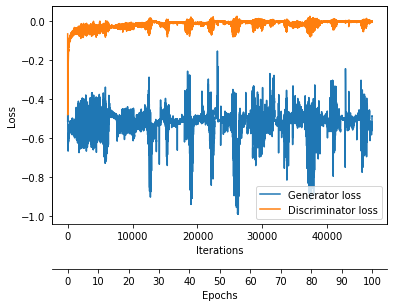

In [8]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.show()

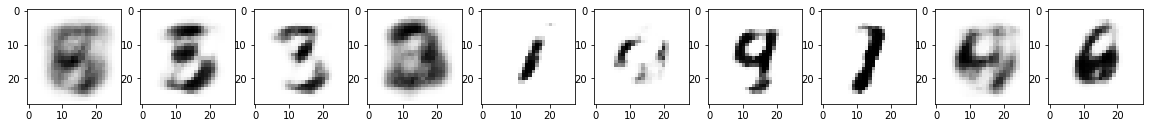

In [10]:
model.eval()
# Make new images
z = torch.zeros((10, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')